In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    DataCollatorWithPadding,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset

In [3]:
os.chdir("./text-empathy/")
from evaluation import pearsonr
from utils.plot import plot

In [12]:
def get_device():
    return torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
tasks = ['empathy', 'distress']

checkpoint = "microsoft/deberta-v3-base"

train_file = "./data/PREPROCESSED-essay-train.csv"
dev_file = "./data/PREPROCESSED-essay-dev.csv"
train_dev_file = "./data/PREPROCESSED-essay-train-dev.csv"
test_file = "./data/PREPROCESSED-test.csv"

In [5]:
def get_data(task, features, batch_size):
    """
    feature: list of features to tokenise
    """
    
    trainloader = load_tokenised_data(
        filename=train_file, task=task, feature_to_tokenise=features, train=True, batch_size=batch_size, shuffle=True
    )

    # devloader in train mode to pass labels
    devloader = load_tokenised_data(
        filename=dev_file, task=task, feature_to_tokenise=features, train=True, batch_size=batch_size, shuffle=False
    )

    return trainloader, devloader

In [6]:
def get_test_data(task, features, batch_size):
    """
    feature: list of features to tokenise
    """
    
    testloader = load_tokenised_data(
        filename=test_file, task=task, feature_to_tokenise=feature, train=False, batch_size=batch_size, shuffle=False
    )

    return testloader

In [7]:
def train(task=tasks[0], lr=1e-5, batch_size=8, n_epochs=3, seed=1, save=False):
    torch.manual_seed(seed)
    
    model = CustomRegressor(n_freeze=0)
    device = get_device()
    model.to(device)

    # print(model)

    opt = torch.optim.AdamW(model.parameters(), lr=lr)
              
    trainloader, devloader = get_data(task=tasks[0], features=features, batch_size=batch_size)

    training_steps = n_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=opt,
        num_warmup_steps=0,
        num_training_steps=training_steps
    )

    train_loss = []
    val_loss = []
    corr = []
    for epoch in range(0, n_epochs):
        total_loss = 0.0
        model.train()
        for batch in trainloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            opt.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            
            opt.step()
            lr_scheduler.step()

            total_loss += loss.item()

        train_loss.append(total_loss / len(trainloader)) # len(trainloader) == num_batches

        total_loss = 0.0
        model.eval()
        y_pred = []
        y_true = []
        for batch in devloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)

            batch_pred = [item for sublist in outputs.logits.tolist() for item in sublist]  #convert 2D list to 1D
            y_pred.extend(batch_pred)
            y_true.extend((batch['labels'].tolist()))
            total_loss += outputs.loss.item()
        
        val_loss.append(total_loss / len(devloader))

        # print(y_pred)
        corr.append(pearsonr(y_true, y_pred))
        print("pearson_r:", corr[-1]) # -1 index refer to the last (current) correlation
        
        if save and epoch > 0 and (corr[-1] > max(corr[:-1])): #after first epoch, if the last score is greater than max of all but last score
            torch.save(model.state_dict(), "model.pth")
            print("Saved the model as model.pth in epoch " + str(epoch+1))
            
    # train-test finished
    plot(
        x=list(range(1, n_epochs+1)),
        y=train_loss,
        y2=val_loss,
        xlabel='Epoch',
        ylabel='Loss',
        legend=['Training loss', 'Validation loss'],
        save=False,
        filename=None
    )

# Demographic as text

In [61]:
features = ['demographic_essay', 'article']

In [62]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

def load_tokenised_data(filename, task, feature_to_tokenise, train, batch_size, shuffle):
    feature_1 = feature_to_tokenise[0]
    feature_2 = feature_to_tokenise[1]
    
    #padding="longest" can be deferred to do dynamic padding
    def tokenise_fn(sentence):
        return tokeniser(sentence[feature_1], sentence[feature_2], truncation=True, max_length=512)
   
    input_data = pd.read_csv(filename, header=0, index_col=0)
    
    if train:
        chosen_data = input_data[feature_to_tokenise + [task]]
    else:
        chosen_data = input_data[feature_to_tokenise]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = feature_to_tokenise)
    
    if train:
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task, "labels") # as huggingface requires
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")
    
    torchloader = torch.utils.data.DataLoader(
        tokenised_hugging_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=data_collator
    )

    return torchloader

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [65]:
class CustomRegressor(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(CustomRegressor, self).__init__()

        self.transformer_last_hidden_size = 768
        self.transformer = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True,
                num_labels=self.transformer_last_hidden_size
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(self.transformer_last_hidden_size, 256)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer.deberta.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer.deberta.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        # print(outputs.keys())
        # will return ['logits', 'hidden_states', 'attentions']

        x = self.dropout(outputs.logits) # output.logits aka pooled output from [CLS] token beacuse of AutoModelForSequenceClassification
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)
        # x = F.tanh(self.fc2(x))
        # x = self.dropout(x)
        logits = self.fc3(x)
                
        loss = None
        if labels is not None:
            loss = F.mse_loss(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [67]:
train(task=tasks[0], lr=1e-5, batch_size=8, n_epochs=20, seed=1)

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: 0.106
pearson_r: 0.227
pearson_r: 0.476
pearson_r: 0.508
pearson_r: 0.505
pearson_r: 0.556
pearson_r: 0.583
pearson_r: 0.555
pearson_r: 0.574
pearson_r: 0.575
pearson_r: 0.57
pearson_r: 0.585
pearson_r: 0.573
pearson_r: 0.59


KeyboardInterrupt: 

# Intermediate fusion of numerical demographic

In [8]:
features = ['essay', 'article']

In [9]:
tokeniser = AutoTokenizer.from_pretrained(checkpoint, use_fast=False) # fast tokeniser showed warning that it may return incorrect tokens

# data collator due to variable max token length per batch size
data_collator = DataCollatorWithPadding(tokenizer = tokeniser)

def load_tokenised_data(filename, task, feature_to_tokenise, train, batch_size, shuffle):
    
    #padding="longest" can be deferred to do dynamic padding
    def tokenise_fn(sentence):
        return tokeniser(sentence[feature_to_tokenise[0]], sentence[feature_to_tokenise[1]], truncation=True, max_length=512)
   
    input_data = pd.read_csv(filename, header=0, index_col=0)

    demog = ["gender", "education", "race", "age", "income"]
    
    if train:
        chosen_data = input_data[feature_to_tokenise + demog + [task]]
    else:
        chosen_data = input_data[feature_to_tokenise + demog]  #test data shouldn't have output label

    hugging_dataset = Dataset.from_pandas(chosen_data, preserve_index=False)

    tokenised_hugging_dataset = hugging_dataset.map(tokenise_fn, batched=True, remove_columns = feature_to_tokenise)
    
    if train:
        tokenised_hugging_dataset = tokenised_hugging_dataset.rename_column(task, "labels") # as huggingface requires
    
    tokenised_hugging_dataset = tokenised_hugging_dataset.with_format("torch")
    
    torchloader = torch.utils.data.DataLoader(
        tokenised_hugging_dataset, shuffle=shuffle, batch_size=batch_size, collate_fn=data_collator
    )

    return torchloader

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
class CustomRegressor(nn.Module):
    def __init__(self, checkpoint="microsoft/deberta-v3-base", n_freeze=-1):
        super(CustomRegressor, self).__init__()

        self.transformer_last_hidden_size = 768
        self.transformer = AutoModelForSequenceClassification.from_pretrained(
            checkpoint,
            config = AutoConfig.from_pretrained(
                checkpoint,
                output_attentions=True,
                output_hidden_states=True,
                num_labels=self.transformer_last_hidden_size
            )
        )
        
        # New layers
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(self.transformer_last_hidden_size, 256)
        self.fc_demog = nn.Linear(5, 512)
        
        self.fc2 = nn.Linear(768, 256) #combined layer from two streams. So, the input = sum of the two streams' o/p
        self.fc3 = nn.Linear(256, 1) # regression problem

        # Freezing layers
        if n_freeze:
            print(f"Freezed layers: {n_freeze}")
            # freeze the embedding layer when n_freeze = -1)
            for param in self.transformer.deberta.embeddings.parameters():
                param.requires_grad = False
    
            # freeze other layers as per n_freeze
            if n_freeze != -1:
                for layer in self.transformer.deberta.encoder.layer[:n_freeze]:
                    for param in layer.parameters():
                        param.requires_grad = False

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None,
        gender = None, education=None, race=None, age=None, income=None
    ):
        outputs = self.transformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        # print(outputs.keys())
        # will return ['logits', 'hidden_states', 'attentions']

        x = self.dropout(outputs.logits) # output.logits aka pooled output from [CLS] token beacuse of AutoModelForSequenceClassification
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)

        demog = torch.stack((gender, education, race, age, income),dim=1)
        
        x_demog = F.tanh(self.fc_demog(demog))
        
        x = torch.cat((x, x_demog), dim=1)
        x = self.dropout(x)

        x = F.tanh(self.fc2(x))
        logits = self.fc3(x)
                
        loss = None
        if labels is not None:
            loss = F.mse_loss(logits.view(-1), labels.view(-1))
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

Map:   0%|          | 0/208 [00:00<?, ? examples/s]

pearson_r: -0.009
pearson_r: 0.348
pearson_r: 0.252
pearson_r: 0.341
pearson_r: 0.236
pearson_r: 0.154
pearson_r: 0.262
pearson_r: 0.335
pearson_r: 0.33
pearson_r: 0.349
pearson_r: 0.369
pearson_r: 0.381
pearson_r: 0.391
pearson_r: 0.413
pearson_r: 0.432
pearson_r: 0.414
pearson_r: 0.417
pearson_r: 0.43
pearson_r: 0.429
pearson_r: 0.431


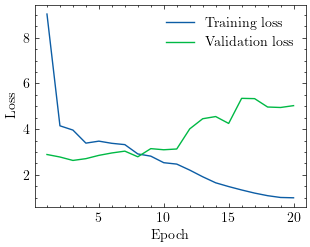

In [11]:
train(task=tasks[0], lr=1e-5, batch_size=8, n_epochs=20, seed=1)

In [14]:
torch.cuda.empty_cache()